# Quick start

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
red, black = '#BF360C', '#263238'

### Create a vector grid from a given raster

In [ ]:
fname_raster = '../files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [ ]:
gdf_grid.head()

,loc_id,geometry
0,0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


<Axes: >

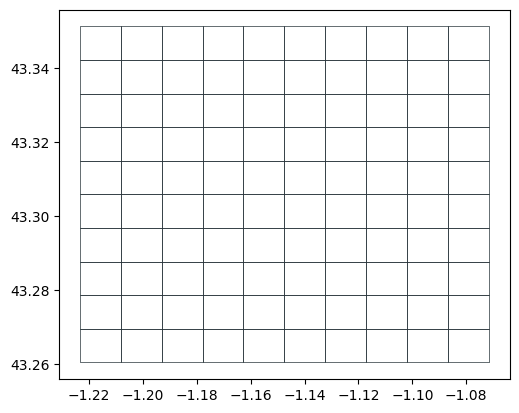

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5)

### Emulating data collection

#### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

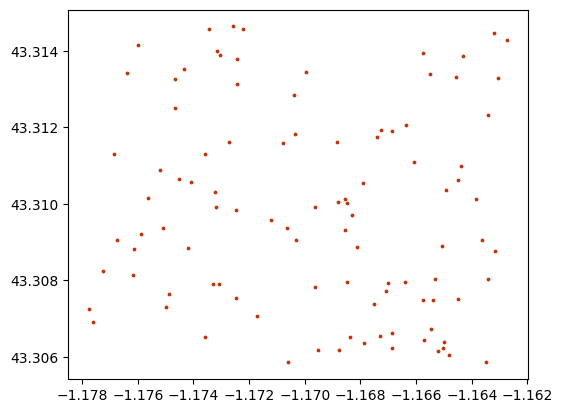

In [ ]:
loc_id = 35
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=3, color=red)

In [ ]:
sampling_locs

35    MULTIPOINT (-1.17776 43.30726, -1.17761 43.306...
Name: sampled_points, dtype: geometry

#### Emulate data collection

We will simulate a data collection process over a set of areas, which could be administrative units or a gridded version of them. For each area, we will specify the number of measurements to be taken, which we will simulate by generating random numbers between 1 and 100.

For each area, we will follow the following steps:

- **Generate random sample locations**: we will create a set of random coordinates within the bounds of the area, where we will simulate the collection of data.
- **Emulate measurement data**: for each sample location, we will extract the corresponding value from a given raster dataset, which we will use to simulate the actual measurement.

This iterative process will allow us to generate a simulated dataset of measurements, which we can then use for further analysis and modeling.

We will emulate data collection from the raster shown below:

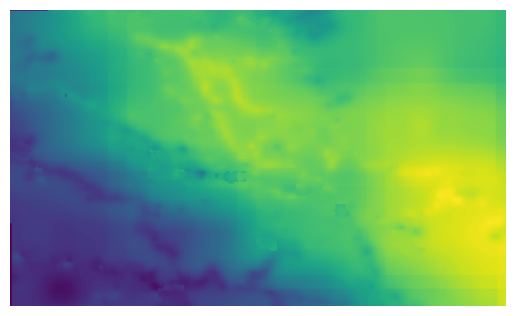

In [ ]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

Let's start with a single area as an example:

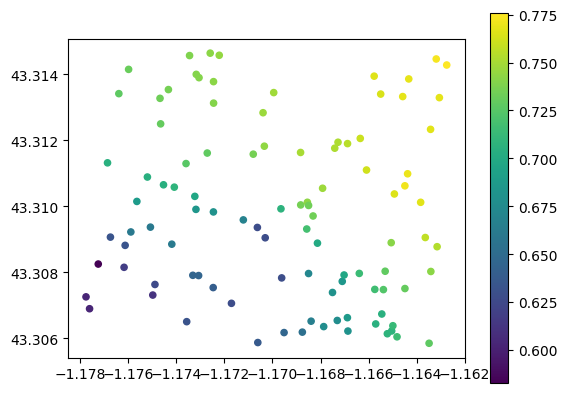

In [ ]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)
gdf_samples.plot(column='value', s=20, legend=True);

In [ ]:
gdf_samples.head()

,loc_id,geometry,value
0,35,POINT (-1.17776 43.30726),0.603114
1,35,POINT (-1.17761 43.30690),0.603114
2,35,POINT (-1.17725 43.30825),0.582775
3,35,POINT (-1.17686 43.31132),0.705486
4,35,POINT (-1.17674 43.30907),0.632870


Than for all areas iteratively:

In [ ]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(0, high=10, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)

In [ ]:
gdf_samples_t0.head()

,loc_id,geometry,value
0,0,POINT (-1.21309 43.26942),0.107513
1,0,POINT (-1.21298 43.26902),0.105533
0,1,POINT (-1.21981 43.27285),0.150703
1,1,POINT (-1.21521 43.27752),0.154031
2,1,POINT (-1.21111 43.27749),0.154695


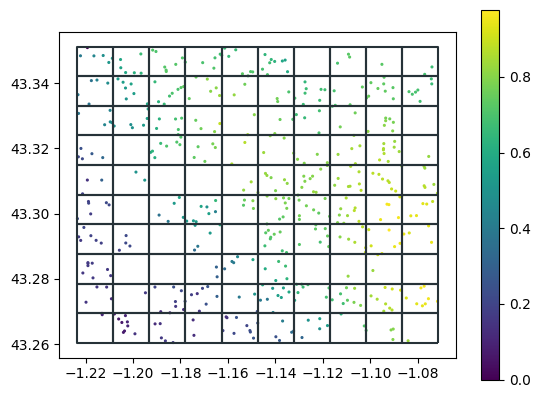

In [ ]:
ax = gdf_samples_t0.plot(column='value', s=1.5, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [ ]:
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), CountCB(),
                               MoranICB(k=5), PriorCB(gdf_grid, fname_raster)])

For a specific `loc_id`:

In [ ]:
state(loc_id=1, as_numpy=False)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I', 'Prior'],
       dtype='<U18'),
 array([0.15469471, 0.11777148, 0.01539069, 4.        ,        nan,
        0.12572713]))

Or for all grid cells:

In [ ]:
state()

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.107513,0.105533,0.000990,2,NaN,0.102492
1,0.154695,0.117771,0.015391,4,NaN,0.125727
2,0.173342,0.158463,0.004991,8,0.392852,0.161802
3,0.211163,0.171735,0.013013,6,0.789155,0.184432
4,0.219737,0.177842,0.015308,6,0.247699,0.201405
...,...,...,...,...,...,...
94,0.941169,0.888865,0.019170,5,NaN,0.876292
95,0.870472,0.828342,0.017880,6,0.832148,0.803670
96,0.819130,0.819130,0.000000,1,NaN,0.763408


Note it only returns loc_id where samples have been collected:

## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5) -- Gives 2 values (value , p-value)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative

! Everything is converted to rank to account for these differences ! 


In [ ]:
# Todo Loc_id 0 gives a Nan result (verify, how to fix)
# Todo MoranI take into account 2 values (verify, how to fix)
benefit_criteria = [True, True, True]
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB()])

optimizer = Optimizer(state=state())
df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [0.3, 0.3, 0.4],  n_method=None, c_method = None, w_method=None, s_method="CP")

df.head()

,rank
loc_id,
83,1
84,2
94,3
82,4
91,5


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
combined_df.head()

,rank,geometry
83,1,"POLYGON ((-1.10190 43.28766, -1.10190 43.29673..."
84,2,"POLYGON ((-1.10190 43.29673, -1.10190 43.30581..."
94,3,"POLYGON ((-1.07150 43.29673, -1.08670 43.29673..."
82,4,"POLYGON ((-1.10190 43.27858, -1.10190 43.28766..."
91,5,"POLYGON ((-1.07150 43.26950, -1.08670 43.26950..."


Follow-up logic

1. use prior (t=0) with weight value 1 to randomly sample, 

2. Rank polygon based on states (loc_id)

3. Map rank of polygon to n_samples for t + 1 (Implement a total budget and give more samples to better ranked polygons)

4. Sample for T + 1 and add samples to gdf_samples_t0

5. Return to step 2

### State T0

In [ ]:
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

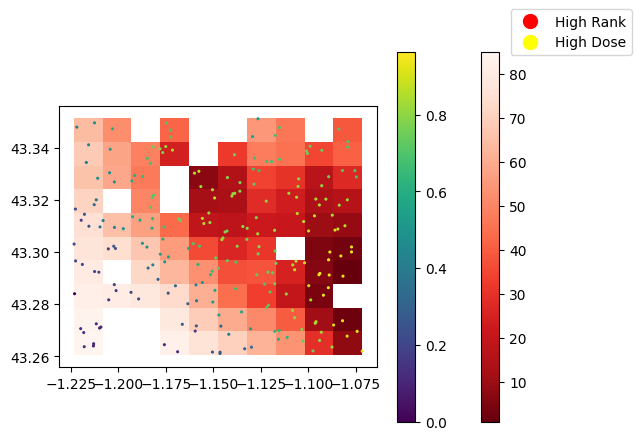

In [87]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(0, high=5, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t = pd.concat(samples_t0)

# 1. base ranking on prior
benefit_criteria = [True]
state = State(gdf_samples_t, [PriorCB(gdf_grid, fname_raster)])
optimizer = Optimizer(state=state())

# 2. rank polygons
df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [1],  n_method="LINEAR1", c_method = None, w_method=None, s_method="CP")
df.head()

# 3. map ranking
combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
combined_df.head()

# 4. Assuming 'rank' is a column in gdf_grid

combined_gdf = gpd.GeoDataFrame(combined_df)
ax = combined_gdf.plot(column='rank', cmap='Reds_r', legend=True)
gdf_samples_t.plot(column='value', ax=ax, cmap='viridis', s=1.5, legend=True)



rank_legend = mlines.Line2D([], [], color='Red', marker='o', linestyle='None',
                            markersize=10, label='High Rank')
value_legend = mlines.Line2D([], [], color='Yellow', marker='o', linestyle='None',
                             markersize=10, label='High Dose')

ax.legend(handles=[rank_legend, value_legend], loc='upper left', bbox_to_anchor=(1.4, 1.4))

# State T + 1

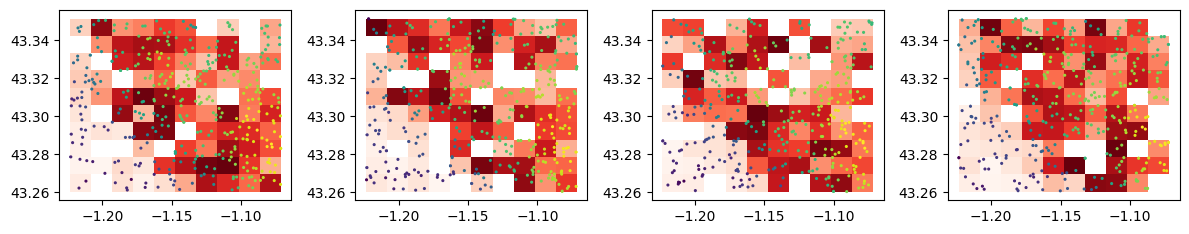

In [88]:
# Setup the figure and subplots grid
number_of_years = 4
fig, axs = plt.subplots(1, number_of_years, figsize=(12, 12))  # Adjust figsize as needed
axs = axs.flatten() 

for n, ax in zip(range(1, number_of_years+1), axs):
    
    sampler = Sampler(fname_raster)
    n_planned = np.random.randint(0, high=5, size=len(gdf_grid), dtype=int)
    loc_ids = gdf_grid.loc_id.values

    samples_t0 = []
    for loc_id, n in zip(loc_ids, n_planned):    
        sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
        gdf_samples = sampler.sample(sampling_locs)
        samples_t0.append(gdf_samples)

    gdf_samples_t = pd.concat(samples_t0)

    # 1. base ranking on prior
    benefit_criteria = [True]
    state = State(gdf_samples_t, [PriorCB(gdf_grid, fname_raster)])
    optimizer = Optimizer(state=state())

    # 2. rank polygons
    df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [1],  n_method="LINEAR1", c_method = None, w_method=None, s_method="CP")
    df.head()

    # 3. map ranking
    combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
    combined_df.head()

    # 4. Assuming 'rank' is a column in gdf_grid

    combined_gdf = gpd.GeoDataFrame(combined_df)
    ax = combined_gdf.plot(column='rank', cmap='Reds_r', ax=ax)
    gdf_samples_t.plot(column='value', ax=ax, cmap='viridis', s=1.5)
    
    # based on the ranking plan a number of samples for the next year (4 policies)
    sampling_policy = [3, 2, 1, 1]

    # Assuming df is your DataFrame and sampling_policy is a list with your policy values
    # Calculate quantiles
    quantiles = df['rank'].quantile([0.25, 0.5, 0.75, 1.0])
    # Use pd.cut to assign each row to a quantile bin
    categories = pd.cut(df['rank'], bins=[-float('inf'), quantiles[0.25], quantiles[0.5], quantiles[0.75], float('inf')], labels=False)
    # Map each quantile bin to its corresponding value in sampling_policy
    df['points_to_sample'] = categories.map(lambda x: sampling_policy[x])

    df.head()  # Display the first few rows to verify the new column
    # 5. determine n_samples for t + 1

    loc_id_sample_size = zip(df.index, df.points_to_sample)

    samples_t = []
    for loc_id, n in loc_id_sample_size:    
        sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
        gdf_samples = sampler.sample(sampling_locs)
        samples_t.append(gdf_samples)

    gdf_samples_t = pd.concat([gdf_samples_t, pd.concat(samples_t)])

    # 6. base ranking on multiple state criteria
    benefit_criteria = [True, True, False, False, True]
    state = State(gdf_samples_t, [MaxCB(), StdCB(), CountCB(),
                                MoranICB(k=5), PriorCB(gdf_grid, fname_raster)])
    optimizer = Optimizer(state=state())

    # 2. rank polygons
    df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [0.2, 0.2, 0.2,0.2, 0.2],  n_method="LINEAR1", c_method = None, w_method=None, s_method="CP")
    df.head()

    # 3. map ranking
    combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
    combined_df.head()

    # 4. Assuming 'rank' is a column in gdf_grid
    # Assuming 'rank' is a column in gdf_grid
    combined_gdf = gpd.GeoDataFrame(combined_df)
    combined_gdf.plot(column='rank', cmap='Reds_r', ax=ax)
    gdf_samples_t.plot(column='value', ax=ax, s=1.5)


plt.tight_layout()  # Adjust layout to make room for the titles and legends
plt.show()

In [ ]:
# https://kapernikov.com/ipywidgets-with-matplotlib/

In [ ]:
df.head(
)

,rank
loc_id,
93,1
91,2
94,3
82,4
84,5
